# Solar Cell Defect Dataset

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="hga92FJ7iHcjjXThQJ5I")
project = rf.workspace("msa-b0qan").project("solar-cell-6pvhl")
dataset = project.version(4).download("folder")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstalle

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to solar-cell-4 in folder:: 100%|██████████| 3954/3954 [00:00<00:00, 6353.18it/s]


In [10]:
from glob import glob
import cv2
from pathlib import Path
import os

In [12]:
!mv solar-cell-4/train/Crack solar-cell-4/train/abnormal
!mv solar-cell-4/train/Not_Crack solar-cell-4/train/normal

# Train

In [13]:
!pip install -U anomalib

In [14]:
import anomalib

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.data.utils import TestSplitMode
from anomalib.models import get_model
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks
from anomalib.utils.loggers import get_experiment_logger

from pytorch_lightning import Trainer, seed_everything

import yaml
from pathlib import Path
from ast import literal_eval

Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'


To use wandb logger install it using `pip install wandb`


In [15]:
model = "fastflow"
image_folder = "solar-cell-4/train"
batch_size = 32
val_ratio = 0.1

In [18]:
# model_config = yaml.safe_load(open(f"./src/anomalib/src/anomalib/models/{model}/config.yaml", "r"))
# config = model_config
config_path = (
    Path(f"{anomalib.__file__}").parent / f"models/{model}/config.yaml"
)
config = get_configurable_parameters(model_name=model, config_path=config_path)
config["dataset"] = yaml.safe_load(open("./config.yaml", "r"))
config["trainer"].update({"default_root_dir":"results/custom/run",
                          "max_epochs": 12})
config["project"].update({"path":"results/custom/run"})
config["optimization"].update({"export_mode":"torch"})

# del config["early_stopping"]

data_config = {
    "format": "folder",
    "name": str(Path(image_folder).name),
    "root": str(Path(image_folder)),
    "path": str(Path(image_folder)),
    "val_split_ratio": float(val_ratio),
    "train_batch_size": int(batch_size),
    "test_batch_size": int(batch_size),
}

config["dataset"].update(data_config)

if config.project.get("seed") is not None:
    seed_everything(config.project.seed)

yaml.dump(literal_eval(str(config)), open("config_dump.yaml","w"))

datamodule = get_datamodule(config)
model = get_model(config)
experiment_logger = get_experiment_logger(config)
callbacks = get_callbacks(config)

trainer = Trainer(
    **config.trainer, logger=experiment_logger, callbacks=callbacks
)

trainer.fit(model=model, datamodule=datamodule)

load_model_callback = LoadModelCallback(
    weights_path=trainer.checkpoint_callback.best_model_path
)
trainer.callbacks.insert(0, load_model_callback)  # pylint: disable=no-member


config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(lim

Training: 0it [00:00, ?it/s]

You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Inference

In [19]:
from anomalib.deploy import TorchInferencer
import cv2
import matplotlib.pyplot as plt

In [26]:
image = cv2.imread("solar-cell-4/train/abnormal/cell0012_png.rf.b89214d7061900c79a2b0d8007c5122e.jpg")[...,::-1]

In [27]:
inferencer = TorchInferencer(path="results/custom/run/weights/torch/model.pt")

In [28]:
predictions = inferencer.predict(image=image)

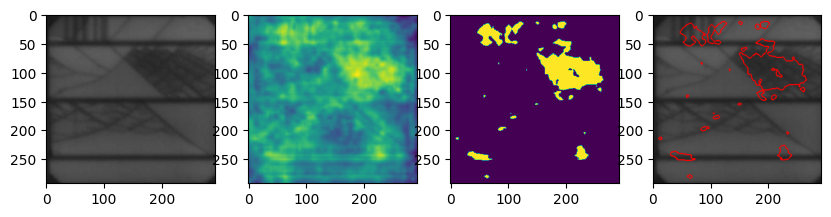

In [30]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(10, 3)
axes[0].imshow(predictions.image)
axes[1].imshow(predictions.anomaly_map)
axes[2].imshow(predictions.pred_mask)
axes[3].imshow(predictions.segmentations)